Do not delete this cell. It defines custom LaTeX commands.
$$
\newcommand{\xb}{\boldsymbol{x}}
\newcommand{\wb}{\boldsymbol{w}}
\newcommand{\pb}{\boldsymbol{p}}
\newcommand{\1}{\mathbb{1}}
$$

# **Convolutions and Convolutional Neural Networks**

**Here you'll experiment with convolutions, on CPUs and GPUs, and with convolutional neural networks.**

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import skimage.data
import skimage.color
import scipy.misc
import scipy.signal
import time

import torch
from torch.autograd import Variable
import torch.nn.functional as F

from matplotlib import rcParams
rcParams['axes.grid'] = False

## **Convolutions with SciPy**

**Let's start by loading a simple image of coffee using scikit-image, converting it to grayscale, and viewing it.**

**You will likely get an error when you run the following line of code. This issue has to do with Google's Colaboratory environment. To fix it, just restart the runtime (`Runtime -> Restart Runtime`) and then run all of the code above again (`Runtime -> Run Before`).**

In [2]:
image = skimage.color.rgb2gray(skimage.data.coffee()).astype(np.float32)

**In the following cell, write code to print this image's `dtype`, `shape`, and minimum and maximum values.**

In [3]:
# TODO
print("dtype: ", image.dtype)
print("shape: ", image.shape)
print("max: ", image.max())
print("min: ", image.min())

dtype:  float32
shape:  (400, 600)
max:  1.0
min:  0.0002827451


**Let's view the image:**

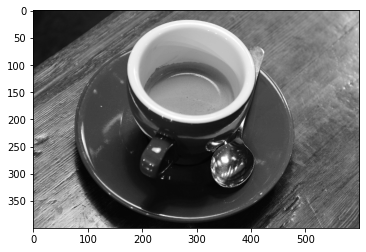

In [4]:
plt.imshow(image)
plt.axis('image')
plt.set_cmap('gray')

**Now let's create a 15 x 15 averaging filter:**

In [5]:
kernel_shape = [15, 15]
kernel = np.ones(kernel_shape, dtype=np.float32) / np.prod(kernel_shape)

**In the following Markdown cell, answer: Why are we dividing by the product of `kernel_shape`'s elements here?**

We want the kernel to be normalized so that it doesn't increase or decrease brightness of the image.

**We can then apply the kernel to our image.**

In [6]:
image_smoothed = scipy.signal.convolve2d(image, kernel, mode='same')
image_smoothed.shape

(400, 600)

**Copy the previous line of code to the cell below and use IPython's `%timeit` magic to see how long this convolution takes.**

In [7]:
%timeit image_smoothed = scipy.signal.convolve2d(image, kernel, mode='same')

10 loops, best of 3: 172 ms per loop


**In the following Markdown cell, answer: Approximately how many milliseconds does it take for this 2-D convolution to complete?**

170ms

**In the following Markdown cell, answer: We specified `mode='same'` so that the output image has the same size as the input image. If we instead retained only *valid* outputs – those computed using only values within `image` and `kernel` – what would the shape of the output image be?**

(400 - 14, 600 - 14) = (386, 586)

**In the following Markdown cell, answer: Expanding on the previous question, suppose you convolve an image of shape `[HEIGHT, WIDTH]` with a kernel of smaller shape `[K_HEIGHT, K_WIDTH]`, where `K_HEIGHT` and `K_WIDTH` are odd. Then what is the shape of the output of the convolution if only *valid* outputs are retained?**

[HEIGHT - (K_HEIGHT - 1), WIDTH - (K_WIDTH - 1)]

**Let's visualize the output of this convolution.**

(-0.5, 599.5, 399.5, -0.5)

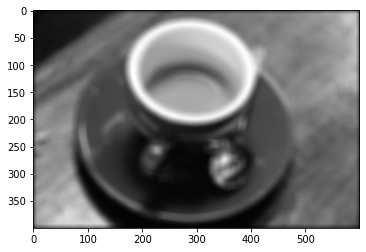

In [8]:
plt.imshow(image_smoothed)
plt.axis('image')

**In the following Markdown cell, answer: Why is there an artificial dark border surrounding this output image (which is not present in the original image above)?**

We extended the image with 0's, so the kernel averaged over 0 values around the edges

**This is the result of using `mode='same'`. Here the original image is effectively padded with 0s so that a 'valid' convolution yields an output that has the same shape as the input image. These 0s are darker than the actual image, so when we include them in our averages, we see this artificial border.**

## **Convolutions with PyTorch (CPU only)**

In [9]:
image_ = Variable(torch.from_numpy(image))
kernel_ = Variable(torch.from_numpy(kernel))
kernel_.shape

torch.Size([15, 15])

**In the following Markdown cell, answer: Look up the documentation for `torch.nn.functional.conv2d`. What shape does it expect for `input`, and what shape does it expect for `weight`? (Note that in our usage, the argument `groups` is 1.)**

torch.nn.functional.conv2d expects input to be a 4d tensor of shape (minibatch,in_channels,iH,iW). It expects weight to be a 4d tensor of shape (out channels , in channels , kH , kW)

**In the following cell, write code to reshape `image_` and `kernel_` so that they can be passed to `torch.nn.functional.conv2d`.**

In [10]:
image_ = torch.reshape(image_, (1,1,400,600))
kernel_ = torch.reshape(kernel_, (1,1,15,15))

**Now let's define appropriate padding (so that our output image again remains the same size at the input image) and use PyTorch's `conv2d` to perform the convolution.**

In [11]:
padding = (kernel_shape[0] // 2, kernel_shape[1] // 2)
image_smoothed_ = F.conv2d(image_, kernel_, padding=padding)

**Copy the previous cell's code to the cell below and use IPython's `%timeit` magic to see how long this convolution takes in PyTorch.**

In [12]:
%timeit F.conv2d(image_, kernel_, padding=padding)

10 loops, best of 3: 20.9 ms per loop


**In the following Markdown cell, answer: Approximately how many milliseconds does it take for this 2-D convolution to complete?**

232 ms

**In the following Markdown cell, answer: How much faster is PyTorch's implementation in comparison to SciPy's? (To answer this, just compute the ratio $T_\text{SciPy}$ / $T_\text{PyTorch}$.)**

172/232 \approx 0.75. So pytorch is about 33% slower.

**In the following Markdown cell, answer: Can you guess why PyTorch is faster here? (It's fine if you aren't sure; if so, just leave it blank.)**

Well, the pytorch implementation isn't faster. But if it used CUDA then im probably would be.

**Again let's visualize the output to make sure it's what we expect.**

(-0.5, 599.5, 399.5, -0.5)

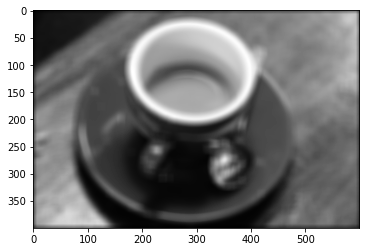

In [13]:
plt.imshow(image_smoothed_.data.numpy().squeeze())
plt.axis('image')

## **Convolutions with PyTorch (GPU)**

**Now let's move on to using CUDA in PyTorch, to leverage GPUs. (If you haven't heard of CUDA, take a quick look at https://en.wikipedia.org/wiki/CUDA.)**

In [14]:
assert torch.cuda.is_available()

**If the above `assert` fails, hit `Edit -> Notebook Settings` and make sure GPU acceleration is enabled.**

**We can then move our images on the GPU and apply the smoothing operation as a convolution.**

In [15]:
image_ = image_.cuda()
kernel_ = kernel_.cuda()

In [16]:
image_smoothed_ = F.conv2d(image_, kernel_, padding=padding)

**Copy the above code to the cell below and use IPython's `%timeit` magic to see how long this convolution takes in PyTorch using our GPU.**

In [17]:
%timeit F.conv2d(image_, kernel_, padding=padding)

10000 loops, best of 3: 348 µs per loop


**In the following Markdown cell, answer: Approximately how many milliseconds does it take for this 2-D convolution to complete?**

348 microseconds

**In the following Markdown cell, answer: How much faster is PyTorch's GPU implementation in comparison to SciPy's CPU implementation? And how much faster is PyTorch's GPU implementation than PyTorch's CPU implementation? (Answer these as done above, as $T_\text{PyTorch GPU}$ / $T_\text{SciPy}$ and $T_\text{PyTorch GPU}$ / $T_\text{PyTorch CPU}$.)**

$T_\text{PyTorch GPU}$ / $T_\text{SciPy} = \frac{348 \mu s}{170 ms} = 0.00196$ 

$T_\text{PyTorch GPU}$ / $T_\text{PyTorch CPU} = \frac{348 \mu s}{232 ms} = 0.0015$

**Now let's go on to convolve an RGB image (height x width x 3) with a kernel that's 15 x 15 x 3.**

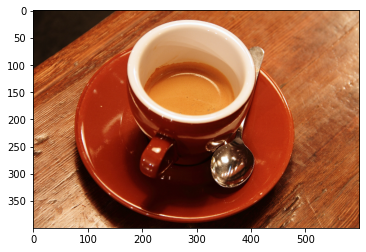

In [18]:
image = skimage.data.coffee().astype(np.float32)
image /= image.max()
plt.imshow(image)

**In the following cell, write code to print this image's `dtype`, `shape`, and minimum and maximum values.**

In [19]:
print("dtype: ", image.dtype)
print("shape: ", image.shape)
print("max: ", image.max())
print("min: ", image.min())

dtype:  float32
shape:  (400, 600, 3)
max:  1.0
min:  0.0


**Let's create a 3D kernel for convolution**

In [35]:
kernel_shape = [15, 15, 3]
kernel = np.ones(kernel_shape, dtype=np.float32) / np.prod(kernel_shape)

**Turn the image and kernel into tensors**

In [36]:
image_ = Variable(torch.from_numpy(image).cuda())
kernel_ = Variable(torch.from_numpy(kernel).cuda())

**In the following cell, write code to permute and reshape axes so that `image_` and `kernel_` have the shapes expected by `torch.nn.functional.conv2d`. (You can use `permute` and `unsqueeze` here.)**

In [37]:
image_ = torch.unsqueeze(image_.permute(2, 0, 1), 0)
kernel_ = torch.unsqueeze(kernel_.permute(2, 0, 1), 0)

**After the `permute`, we need to make our Variables contiguous. (`permute` changes the order in which we view memory, but avoids rearranging the order explicitly. Thus we need to explicitly reorder the memory so that future manipulations can operate as expected.)**

In [38]:
image_ = image_.contiguous()
kernel_ = kernel_.contiguous()

**In the following cell, write code to print the shape of `image_` and `kernel_`, and confirm they're what you expect.**

In [39]:
print(image_.shape)
print(kernel_.shape)

torch.Size([1, 3, 400, 600])
torch.Size([1, 3, 15, 15])


**Convolve the image again with the kernel.**

In [40]:
output_ = F.conv2d(image_, kernel_, padding=padding)

**In the following cell, write code to print the `type` and `shape` of `output_.data`.**

In [42]:
print(output_.dtype)
print(output_.shape)

torch.float32
torch.Size([1, 1, 400, 600])


**In the following Markdown cell, answer: Why does the output have 1 output channel instead of 3?**

We only convolved the input with one filter of shape 3x15x15. That results in only one output channel.

**Finally, let's visualize the result.**

(-0.5, 599.5, 399.5, -0.5)

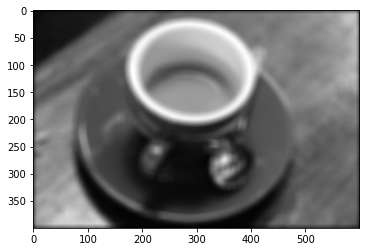

In [43]:
plt.imshow(output_.data.cpu().numpy().squeeze())
plt.axis('image')

## **MNIST Classification with Extremely Simple CNNs**

**We can first setup the necessary environment and constants**

In [44]:
import torchvision

from pathlib import Path
HOME = Path.home()
MNIST_PATH = HOME / 'data' / 'mnist'

NUM_CLASSES = 10
CHANNELS = 1
HEIGHT = 28
WIDTH = 28

**We're going to load the official train set and never touch the true test set in these experiments, which consists of 10,000 separate examples. We'll instead split our training set into a set for training and a set for validation.**

In [45]:
official_mnist_train = torchvision.datasets.MNIST(str(MNIST_PATH), train=True, download=True)
official_train_images = official_mnist_train.train_data.numpy().astype(np.float32)
official_train_labels = official_mnist_train.train_labels.numpy().astype(np.int)

Extracting /root/data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /root/data/mnist/MNIST/raw


Extracting /root/data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /root/data/mnist/MNIST/raw


Extracting /root/data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/data/mnist/MNIST/raw




Extracting /root/data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/data/mnist/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [46]:
print(official_train_images.shape)
print(official_train_labels.shape)

(60000, 28, 28)
(60000,)


**Let's view a few examples:**

[5 0 4 1 9 2 1 3 1 4]


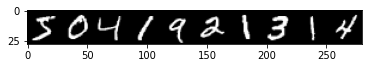

In [47]:
example_images = np.concatenate(official_train_images[:10], axis=1)
example_labels = official_train_labels[:10]
print(example_labels)
plt.imshow(example_images)

**Here we'll split our training set into 55000 for training and the rest for validation.**

In [48]:
train_images, val_images = np.split(official_train_images, [55000])
train_labels, val_labels = np.split(official_train_labels, [55000])

In [49]:
print(train_images.shape, train_labels.shape)
print(val_images.shape, val_labels.shape)

(55000, 28, 28) (55000,)
(5000, 28, 28) (5000,)


**And we'll normalize our data in one of the simplest ways possible: centering and scaling on an image-by-image basis.**

In [50]:
def normalize_stats_image_by_image(images):
  mean = images.mean(axis=(1,2), keepdims=True)
  stdev = images.std(axis=(1,2), keepdims=True)
  return (images - mean) / stdev

In [51]:
train_images = normalize_stats_image_by_image(train_images)
val_images = normalize_stats_image_by_image(val_images)

**We can print the mean and stddev to make sure that normalization is done correctly.**

In [52]:
print(train_images[:3].mean(axis=(1, 2)))
print(train_images[:3].std(axis=(1, 2)))
print(val_images[:3].mean(axis=(1, 2)))
print(val_images[:3].std(axis=(1, 2)))

[ 0.0000000e+00 -1.2164214e-08  0.0000000e+00]
[1. 1. 1.]
[-3.8925482e-08 -4.8656852e-09 -4.3791168e-08]
[1. 1. 1.]


**We'll define a function to return a batch of examples. Since we assume GPU is available, we also move these images to the GPU.**

In [53]:
def batch(batch_size, training=True):
  """Create a batch of examples.
  
  This creates a batch of input images and a batch of corresponding
  ground-truth labels. We assume CUDA is available (with a GPU).
  
  Args:
    batch_size: An integer.
    training: A boolean. If True, grab examples from the training
      set; otherwise, grab them from the validation set.
  
  Returns:
    A tuple,
    input_batch: A Variable of floats with shape
      [batch_size, 1, height, width]
    label_batch: A Variable of ints with shape
      [batch_size].
  """
  if training:
    random_ind = np.random.choice(train_images.shape[0], size=batch_size, replace=False)
    input_batch = train_images[random_ind]
    label_batch = train_labels[random_ind]
  else:
    input_batch = val_images[:batch_size]
    label_batch = val_labels[:batch_size]
  
  input_batch = input_batch[:, np.newaxis, :, :]
  
  volatile = not training
  input_batch = Variable(torch.from_numpy(input_batch).cuda(), volatile=volatile)
  label_batch = Variable(torch.from_numpy(label_batch).cuda(), volatile=volatile)
  
  return input_batch, label_batch

**Below, you will define a `SimpleCNN` with some significant restrictions on the model class:**

**(1) Input to conv_final needs to be a single pixel (see comments where it is defined).** 

**(2) Only Convolutions and ReLUs can be used. In other words, do not use max pooling, do not use dropout, etc.**

**The purpose of this is to (1) gain competency with the basic settings for convolutions and (2) develop a practical sense for how important these basic settings are.**

**Target: Try to achieve better than 2% error.**

**Hint 1: You can use the `stride` argument in the convolutions.**

**Hint 2: This can easily be achieved in well under 5000 iterations using the same optimizer settings as below (Adam with a learning rate of 0.001).**

In [125]:
class SimpleCNN(torch.nn.Module):
  """A simple convolutional network.
  
  Map from inputs with shape [batch_size, 1, height, width] to
  outputs with shape [batch_size, 1].
  """
  
  def __init__(self):
    super().__init__()
    self.conv1 = torch.nn.Conv2d(1, 32, kernel_size=3, padding=7//2) # feel free to change these parameters.
    # TODO
    # (You may also need to modify conv_final.)
    self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, padding=0, stride=2)
    self.conv3 = torch.nn.Conv2d(64, 128, kernel_size=3, padding=0, stride=2)
    self.conv4 = torch.nn.Conv2d(128, 128, kernel_size=7, padding=0, stride=2)
    
    # Here the input to conv_final should be a single pixel, as can be obtained
    # by pooling spatially over all pixels. The goal of conv_final is to map
    # from some number of channels to 10, one for each possible class.
    
    # Here, in_channel = 128, but feel free to change that. All other parameters for conv_final should remain the same.
    self.conv_final = torch.nn.Conv2d(128, 10, kernel_size=1)
    
  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = F.relu(self.conv3(x))
    x = F.relu(self.conv4(x))
    x = self.conv_final(x)
    
    return x.reshape((x.shape[0], 10))

**And instantiate our model... notice again that we assume CUDA is available, and that moving all parameters to the GPU is as simple as running `model.cuda()`.**

In [127]:
model = SimpleCNN()
model.cuda()

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(3, 3))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
  (conv4): Conv2d(128, 128, kernel_size=(7, 7), stride=(2, 2))
  (conv_final): Conv2d(128, 10, kernel_size=(1, 1), stride=(1, 1))
)

In [128]:
input_batch, label_batch = batch(val_images.shape[0], training=False)
x = model(input_batch)
print(x.shape)
print(label_batch.shape)

torch.Size([5000, 10])
torch.Size([5000])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


In [129]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

**Helper function that performs the forward pass, backpropagation, and then gradient update steps for a single batch.**

In [130]:
def train_step(batch_size=128):
  
  model.train()

  input_batch, label_batch = batch(batch_size, training=True)
  output_batch = model(input_batch)
  
  loss = F.cross_entropy(output_batch, label_batch)
  _, pred_batch = torch.max(output_batch, dim=1)
  error_rate = 1.0 - (pred_batch == label_batch).float().mean()

  optimizer.zero_grad()
  loss.backward()
  
  optimizer.step()
  
  return loss.data, error_rate.data

**Evaluation function**

In [131]:
def val():
  
  model.eval()
  input_batch, label_batch = batch(val_images.shape[0], training=False)
  output_batch = model(input_batch)

  loss = F.cross_entropy(output_batch, label_batch)
  _, pred_batch = torch.max(output_batch, dim=1)
  error_rate = 1.0 - (pred_batch == label_batch).float().mean()
  
  return loss.data, error_rate.data

**Finally, let's train, and also plot loss and error rate as a function of iteration.**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Step     0: Obtained a best validation error of 0.903.
Step    50: Obtained a best validation error of 0.060.
Step   100: Obtained a best validation error of 0.043.
Step   150: Obtained a best validation error of 0.028.
Step   200: Obtained a best validation error of 0.025.
Step   250: Obtained a best validation error of 0.023.
Step   300: Obtained a best validation error of 0.017.
Step   400: Obtained a best validation error of 0.016.
Step   550: Obtained a best validation error of 0.013.
Step   950: Obtained a best validation error of 0.011.
Step  1050: Obtained a best validation error of 0.010.
Step  1550: Obtained a best validation error of 0.009.
Step  1800: Obtained a best validation error of 0.008.
Step  2950: Obtained a best validation error of 0.008.
Step  4050: Obtained a best validation error of 0.008.


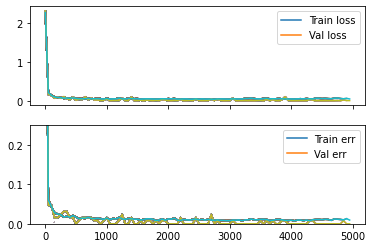

In [132]:
# Let's make sure we always start from scratch (that is,
# without starting from parameters from a previous run).
for module in model.children():
  module.reset_parameters()

info = []
fig, ax = plt.subplots(2, 1, sharex=True)
num_steps = 5000
num_steps_per_val = 50
best_val_err = 1.0
for step in range(num_steps):
  train_loss, train_err = train_step()
  if step % num_steps_per_val == 0:
    val_loss, val_err = val()
    if val_err < best_val_err:
      best_val_err = val_err
      print('Step {:5d}: Obtained a best validation error of {:.3f}.'.format(step, best_val_err))
    info.append([step, train_loss, val_loss, train_err, val_err])
    x, y11, y12, y21, y22 = zip(*info)
    ax[0].plot(x, y11, x, y12)
    ax[0].legend(['Train loss', 'Val loss'])
    ax[1].plot(x, y21, x, y22)
    ax[1].legend(['Train err', 'Val err'])
    ax[1].set_ylim([0.0, 0.25])